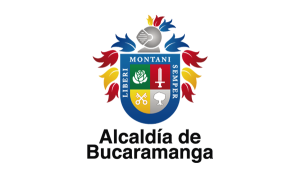

## Secretaría de Salud y Ambiente
---







<a href="https://colab.research.google.com/github/JotaRodriguez94/Forecasting_COVID_BGA/blob/main/EDA_COVID_19_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

## Exploración y análisis de las series temporales relacionadas con COVID-19

In [1]:
#@title Importar dependencias
# Uncomment this block to install necessary dependencies.
#!pip install statsmodels
# download the code
!git clone https://github.com/JotaRodriguez94/Forecasting_COVID_BGA.git
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
from Forecasting_COVID_BGA import utils
from collections import defaultdict
import datetime
#importlib.reload(utils);

seed = 7
plt.style.use('ggplot')
np.random.seed(seed=seed)

Cloning into 'Forecasting_COVID_BGA'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 55 (delta 16), reused 38 (delta 10), pack-reused 0
Unpacking objects: 100% (55/55), done.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [45]:
#@title Descargar los datos y procesarlos
!wget -q https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv -O Casos_positivos_de_COVID-19_en_Colombia.csv
data_colombia = pd.read_csv('/content/Casos_positivos_de_COVID-19_en_Colombia.csv')
!wget -q https://covid.ourworldindata.org/data/owid-covid-data.xlsx -O owid-covid-data.xlsx  
data = pd.read_excel('/content/owid-covid-data.xlsx')
# preproccesing data
# preproccesing data
df_join = utils.preproccesing_data(data, data_colombia)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (14,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Max value in days 313


In [48]:
#@title Seleccionar los países, ciudades y departamentos a usar
# select the countries. cities and deps
countries_top = ['Argentina', 'Bangladesh', 'Belgium', 'Brazil', 'Canada', 'Chile', 'Czech Republic',
'France', 'Germany', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Italy', 'Mexico',
'Morocco', 'Netherlands', 'Pakistan', 'Peru', 'Philippines', 'Poland', 'Romania',
'Russia', 'Saudi Arabia', 'South Africa', 'Spain', 'Turkey', 'Ukraine', 'United Kingdom',
'United States']
dep_top = ['ANTIOQUIA', 'ATLANTICO', 'CUNDINAMARCA', 'SANTANDER', 'VALLE']
cities_top = ['BARRANQUILLA', 'BOGOTA', 'BUCARAMANGA', 'CALI', 'CARTAGENA', 'MEDELLIN']

series = cities_top + dep_top + countries_top
df_join = df_join[series]
df_join

,BARRANQUILLA,BOGOTA,BUCARAMANGA,CALI,CARTAGENA,MEDELLIN,ANTIOQUIA,ATLANTICO,CUNDINAMARCA,SANTANDER,VALLE,Argentina,Bangladesh,Belgium,Brazil,Canada,Chile,Czech Republic,France,Germany,India,Indonesia,Iran,Iraq,Israel,Italy,Mexico,Morocco,Netherlands,Pakistan,Peru,Philippines,Poland,Romania,Russia,Saudi Arabia,South Africa,Spain,Turkey,Ukraine,United Kingdom,United States
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-31,3.0,1.0,1.0,19.0,13.0,8.0,12.0,1.0,3.0,2.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01,3.0,1.0,1.0,19.0,13.0,8.0,12.0,1.0,3.0,2.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,3.0,1.0,1.0,19.0,13.0,8.0,12.0,1.0,3.0,2.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,3.0,1.0,1.0,19.0,13.0,8.0,12.0,1.0,3.0,2.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,3.0,1.0,1.0,19.0,13.0,8.0,12.0,1.0,3.0,2.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-03,38.0,1413.0,34.0,231.0,11.0,216.0,391.0,27.0,62.0,100.0,316.0,9598.0,1736.0,6272.0,8501.0,3422.0,1324.0,9252.0,52518.0,15352.0,38310.0,2618.0,8289.0,3413.0,852.0,22253.0,3763.0,2526.0,8278.0,1167.0,1634.0,2287.0,15578.0,4041.0,18257.0,381.0,772.0,55019.0,2302.0,6754.0,18950.0,83883.0
2020-11-04,5.0,613.0,6.0,37.0,4.0,54.0,99.0,4.0,18.0,16.0,58.0,12145.0,1659.0,2663.0,11843.0,4672.0,1014.0,12089.0,36330.0,17214.0,46253.0,2973.0,8932.0,3595.0,809.0,28241.0,5250.0,4495.0,7729.0,1313.0,2357.0,1761.0,19364.0,7733.0,18648.0,473.0,1241.0,18669.0,2343.0,8899.0,20018.0,92734.0
2020-11-05,1.0,43.0,7.0,16.0,1.0,8.0,12.0,2.0,1.0,24.0,1.0,10652.0,1517.0,13546.0,23976.0,2768.0,840.0,15731.0,40558.0,19990.0,50210.0,3356.0,8452.0,3574.0,764.0,30548.0,5225.0,5745.0,7622.0,1302.0,2885.0,976.0,24692.0,8651.0,19768.0,426.0,1712.0,25042.0,2391.0,9524.0,25177.0,102507.0


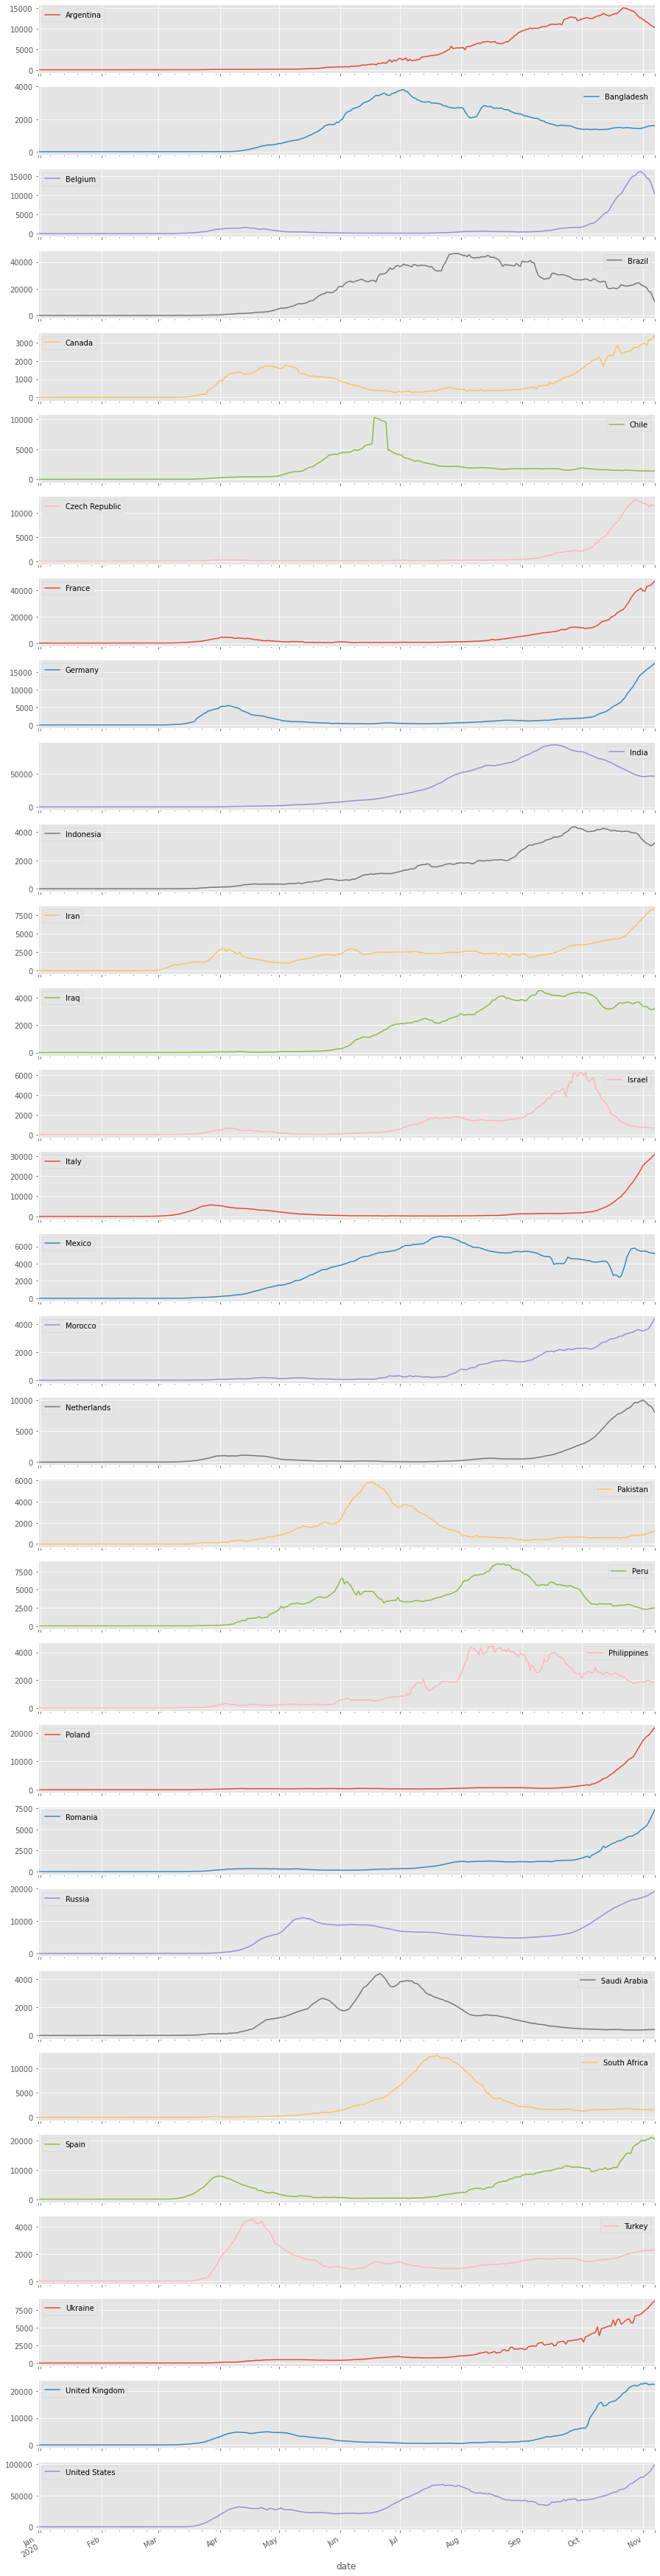

In [50]:
#@title Visualización países - Suavizado semanal
df_join[countries_top].iloc[:, :].rolling(7).mean().fillna(
    axis=0, method='backfill', inplace=False).plot(subplots=True,
                                                   figsize=(15, 70));

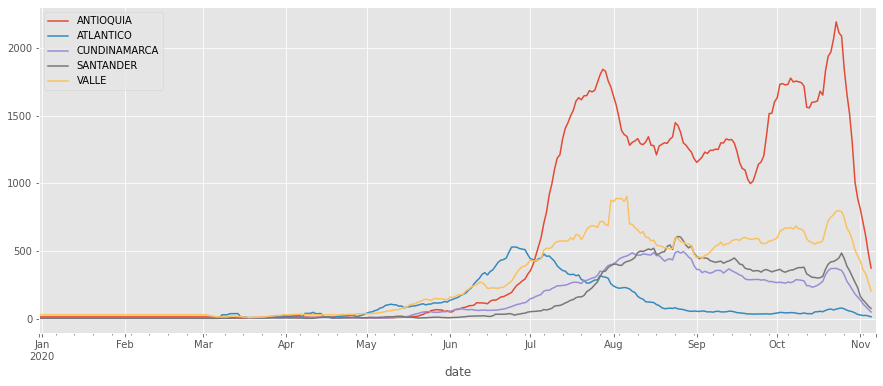

In [57]:
#@title Visualización Departamentos - Suavizado semanal
df_join[dep_top].iloc[:, :].rolling(7).mean().fillna(
    axis=0, method='backfill', inplace=False).plot(subplots=False,
                                                   figsize=(15, 6));

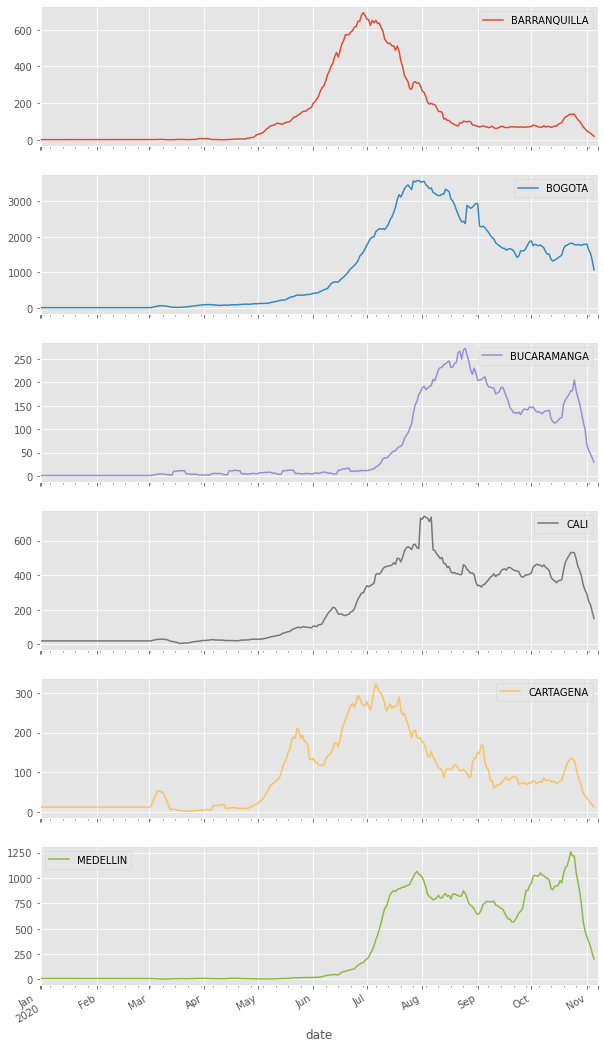

In [53]:
#@title Visualización Ciudades - Suavizado semanal
df_join[cities_top].iloc[:, :].rolling(7).mean().fillna(
    axis=0, method='backfill', inplace=False).plot(subplots=True,
                                                   figsize=(10, 20));

Análisis de tendencia y autocorrelación


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


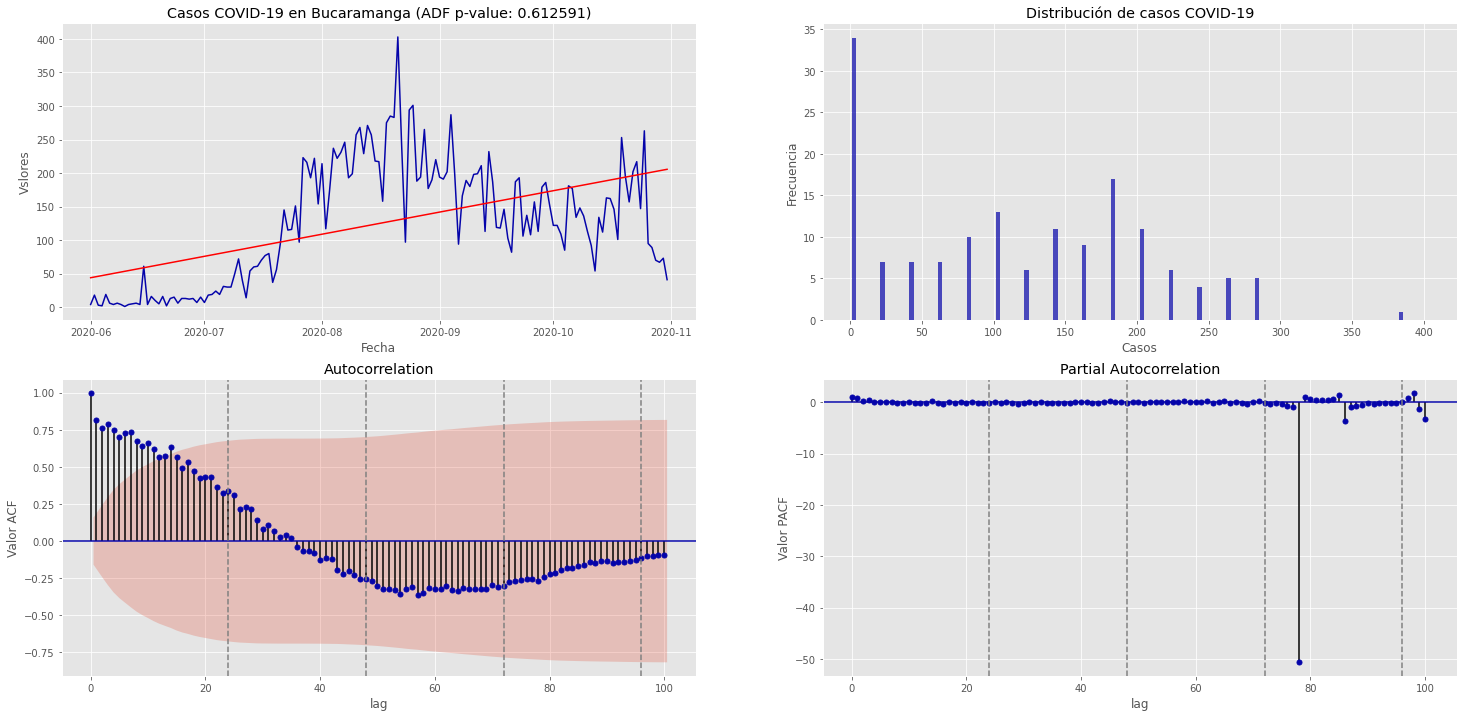

Descomposición


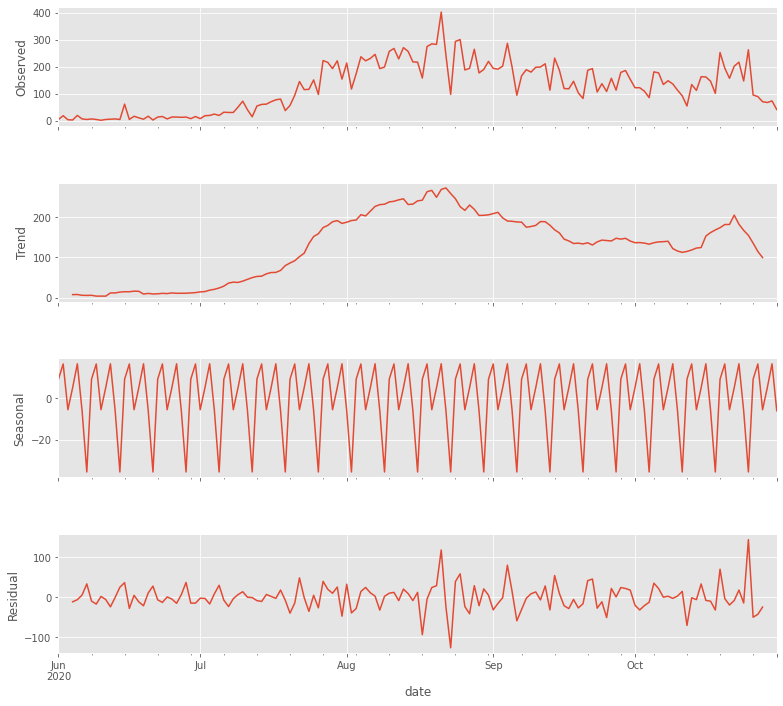

In [67]:
#@title Análisis del comportamiento en Bucaramanga
Fecha_inicial = '2020-06-01' #@param {type:"date"}
Fecha_final = '2020-10-31' #@param {type:"date"}

initial_date = datetime.datetime.strptime(Fecha_inicial, '%Y-%m-%d')
final_date = datetime.datetime.strptime(Fecha_final, '%Y-%m-%d')
serie_bucaramanga = df_join.loc[(df_join.index >= initial_date) & (
    df_join.index <= final_date), 'BUCARAMANGA'].fillna(axis=0,
                                                        method='backfill',
                                                        inplace=False)
print('Análisis de tendencia y autocorrelación')
utils.ts_analysis_plots(serie_bucaramanga)

print('Descomposición')
res = seasonal_decompose(serie_bucaramanga, model='additive')
fig = res.plot()
fig.set_size_inches((12, 12))